In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import urllib.request 

In [0]:
### helper functions for building cnn

def conv(x, W):
    """simple wrapper for tf.nn.conv2d"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool(x):
    """simple wrapper for tf.nn.max_pool with stride size 2"""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def norm(x): 
    """simple wrapper for tf.nn.lrn... See section 3.3 of Krizhevsky 2012 for details"""
    return tf.nn.lrn(x, depth_radius=5, bias=2, alpha=1e-4, beta=0.75)

In [0]:
#helper function to normalize and plot RGB images 

def plot_image(x):
  x_min_0 = np.amin(x[:,:,0])
  x_max_0 = np.amax(x[:,:,0])
  x_min_1 = np.amin(x[:,:,1])
  x_max_1 = np.amax(x[:,:,1])
  x_min_2 = np.amin(x[:,:,2])
  x_max_2 = np.amax(x[:,:,2])
  
  scaled_0 = (x[:,:,0] - x_min_0)/(x_max_0 - x_min_0)
  scaled_1 = (x[:,:,1] - x_min_1)/(x_max_1 - x_min_1)
  scaled_2 = (x[:,:,2] - x_min_2)/(x_max_2 - x_min_2)
 
  
  scaled_image = np.stack([scaled_0,scaled_1,scaled_2],axis = 2)
  plt.imshow(scaled_image)

In [0]:
### cnn model class, used to store weights and compute intermediate network outputs

class Model:
  
  def __init__(self,_n1,_n2,_n3,_W_conv1,_b_conv1,_W_conv2,_b_conv2,_W_fc1,_b_fc1,_W_fc2,_b_fc2):
    self._n1 = _n1
    self._n2 = _n2
    self._n3 = _n3
    self._W_conv1 = _W_conv1
    self._W_conv2 = _W_conv2
    self._b_conv1 = _b_conv1
    self._b_conv2 = _b_conv2
    self._W_fc1 = _W_fc1
    self._W_fc2 = _W_fc2
    self._b_fc1 = _b_fc1
    self._b_fc2 = _b_fc2
  
  def get_logits(self,image):
    fc1 = self.get_layer_output(image,3,False)
    logits = tf.add(tf.matmul(fc1,self._W_fc2),self._b_fc2)
    probs = tf.nn.softmax(logits)
    return logits
  
  def get_layer_output(self,image,layer,pre_relu = False):  
    relu1_in = tf.add(conv(image,self._W_conv1),self._b_conv1)
    _h_conv1 = tf.nn.relu(relu1_in)
    _h_pool1 = maxpool(_h_conv1)
    
    _h_norm1 = norm(_h_pool1)
    
    relu2_in = tf.add(conv(_h_norm1,self._W_conv2),self._b_conv2)
    _h_conv2 = tf.nn.relu(relu2_in)
    _h_pool2 = maxpool(_h_conv2)
    
    _h_norm2 = norm(_h_pool2)
      
    h_norm2_flat = tf.reshape(_h_norm2, [-1, 8*8*self._n2])  
    
    fc_relu_in = tf.add(tf.matmul(h_norm2_flat, self._W_fc1), self._b_fc1)
    _h_fc1 = tf.nn.relu(fc_relu_in)
    
    if layer == 1 and pre_relu == False:
      return _h_conv1
    if layer == 1 and pre_relu == True:
      return relu1_in
    if layer == 2 and pre_relu == False:
      return _h_conv2
    if layer == 2 and pre_relu == True:
      return relu2_in
    if layer == 3: 
      return _h_fc1
   
    return None
  
  def get_channel(self,image,layer,channel,pre_relu = False):
    layer_out = self.get_layer_output(image,layer,pre_relu)
    return layer_out[:,:,:,channel-1]
                              
  def get_channel_loss(self,image,layer,channel,pre_relu = False):
    channel_out = self.get_channel(image,layer,channel,pre_relu)
    return tf.reduce_mean(channel_out)
  
  def get_logit_loss(self,image,logit_ind):
    logits = self.get_logits(image)
    return logits[0,logit_ind]    
    

In [0]:
# download SVHN dataset

urllib.request.urlretrieve ("http://ufldl.stanford.edu/housenumbers/train_32x32.mat", "train_32x32.mat")
urllib.request.urlretrieve ("http://ufldl.stanford.edu/housenumbers/test_32x32.mat", "test_32x32.mat")

mat_train = spio.loadmat('train_32x32.mat')
mat_test = spio.loadmat('test_32x32.mat')

In [0]:
# Center the data

n_val = 5000
[inh,inw,inc,n] = mat_train['X'].shape
X_train = np.empty(shape=(inh,inw,inc,n-n_val), dtype=np.float32)
X_val = np.empty(shape=(inh,inw,inc,n_val), dtype=np.float32)
  
for i in range(n-n_val):
  for c in range(3):
    X_train[:,:,c,i] = (mat_train['X'][:,:,c,i] - np.mean(mat_train['X'][:,:,c,i]))/255
for i in range(n_val):
  for c in range(3):
    X_val[:,:,c,i] = (mat_train['X'][:,:,c,i-n_val] - np.mean(mat_train['X'][:,:,c,i-n_val]))/255

In [0]:
# reformat class labels

y_train0 = np.array([0 if y==10 else y[0] for y in mat_train['y'][:n-n_val]]).reshape([n-n_val,1])
y_train = mat_train['y']

y_train0 = np.array([0 if y==10 else y[0] for y in mat_train['y'][:n-n_val]]).reshape([n-n_val,1])
y_vals = np.unique(y_train0).size
y_onehot = (np.arange(y_vals) == y_train0).astype(int)

y_train = y_train0
y_val = np.array([0 if y==10 else y[0] for y in mat_train['y'][-n_val:]]).reshape([n_val,1])
y_onehot_val = (np.arange(np.unique(y_val).size) == y_val).astype(int)

In [0]:
G = tf.Graph()

## train the network on the SVHN dataset

with G.as_default():

  x = tf.placeholder(tf.float32, [None, 32*32*3], name='x')
  y = tf.placeholder(tf.float32, [None, 10], name='y')
  pkeep = tf.placeholder(tf.float32, name='pkeep')
  
  # 2 layer cnn
  n1 = 32
  n2 = 64
  n3 = 1024
  x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
  # cnn layer 1
  W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 3, n1])
  b_conv1 = tf.get_variable('b_conv1', shape=[n1])
  h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
  
  h_conv1_shape = tf.shape(h_conv1)
  # pool 1
  h_pool1 = maxpool(h_conv1)
  # norm 1
  h_norm1 = norm(h_pool1)
  # cnn layer 2
  W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, n1, n2])
  b_conv2 = tf.get_variable('b_conv2', shape=[n2])
  h_conv2 = tf.nn.relu(tf.add(conv(h_norm1, W_conv2), b_conv2))
  
  h_conv2_shape = tf.shape(h_conv2)
  # pool 2
  h_pool2 = maxpool(h_conv2)
  # norm 2
  h_norm2 = norm(h_pool2)
  # fc layer to logits (8x8 since 2 rounds of maxpool)
  h_norm2_flat = tf.reshape(h_norm2, [-1, 8*8*n2])
  W_fc1 = tf.get_variable('W_fc1', shape=[8*8*n2, n3])
  b_fc1 = tf.get_variable('b_fc1', shape=[n3])
  h_fc1 = tf.nn.relu(tf.add(tf.matmul(h_norm2_flat, W_fc1), b_fc1))
  # insert a dropout layer here.
  h_fc1_drop = tf.nn.dropout(h_fc1, pkeep)
  # one more fc layer
  # ... again, this is the logistic layer with softmax readout
  W_fc2 = tf.get_variable('W_fc2', shape=[n3,10])
  b_fc2 = tf.get_variable('b_fc2', shape=[10])
  logits = tf.add(tf.matmul(h_fc1_drop, W_fc2), b_fc2, name='logits_cnn_cpncpnfdf')
  
  sm_ce = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits, name='cross_ent_terms')
  loss = tf.reduce_mean(sm_ce, name='cross_ent')
  
  prediction = tf.argmax(logits, 1, name='pred_class')
  true_label = tf.argmax(y, 1, name='true_class')
  accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))
 
  opt = tf.train.AdamOptimizer(1e-4)
  train_step = opt.minimize(loss)
  
  batch_size = 100
  saver = tf.train.Saver()
  
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(5001):
        batch = np.floor(np.random.rand(batch_size)*(n-n_val)).astype(int)
        X_batch = X_train[:,:,:,batch].transpose([3,0,1,2]).reshape([batch_size,-1])
        y_batch = y_onehot[batch]

        # now run
        sess.run(train_step,feed_dict={x: X_batch, y: y_batch, pkeep:0.85})


        # print diagnostics
        if i%100 == 0:
            X_batch = X_train[:,:,:,0:1000].transpose([3,0,1,2]).reshape([1000,-1])
            y_batch = y_onehot[0:1000]
            (train_error,train_logits) = sess.run((accuracy,logits), {x: X_batch, y: y_batch, pkeep:1.0})
            print("\rStep {0:3d}: training accuracy {1:0.4f}".format(i, train_error), flush=True)
            # further diagnostics

        if i%100 == 0:
            X_batch = X_val.transpose([3,0,1,2]).reshape([n_val,-1])
            y_batch = y_onehot_val
            val_error = sess.run(accuracy ,{x:X_batch, y:y_batch, pkeep:1.0})
            print("\rStep {0:3d}: val accuracy {1:0.4f}".format(i, val_error), flush=True)
    
    save_path = saver.save(sess, "/tmp_svhn/model.ckpt")
    
    
    

INFO:tensorflow:Restoring parameters from /tmp_svhn/model.ckpt


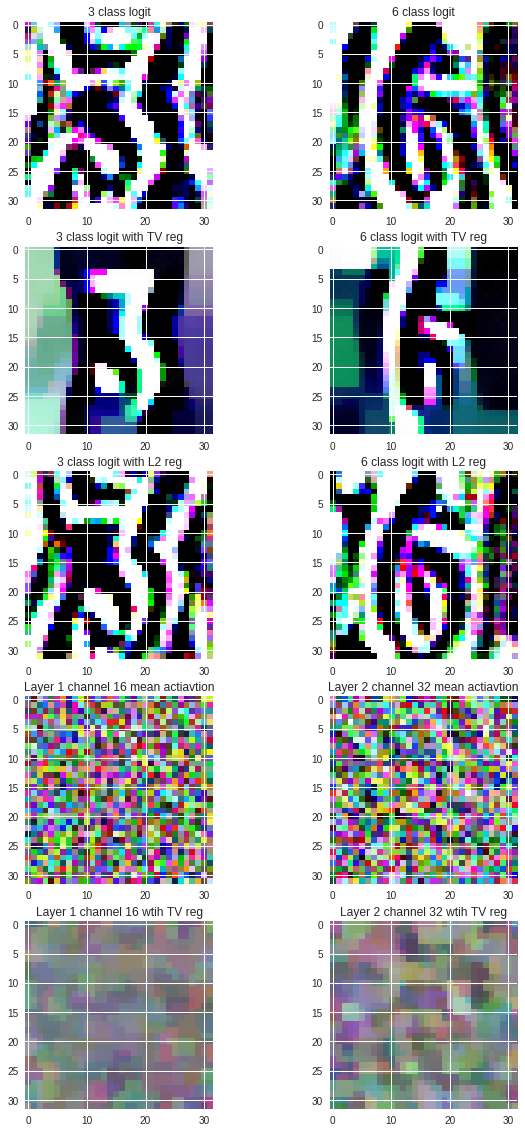

In [0]:
## Optimize and display images

with G.as_default():
  
  cnn_model = Model(n1,n2,n3,W_conv1,b_conv1,W_conv2,b_conv2,W_fc1,b_fc1,W_fc2,b_fc2)
  rand = tf.Variable(tf.random.uniform([32,32,3],minval = 0, maxval = 1,dtype = tf.float32))
  rand_image = tf.reshape(rand,[-1,32,32,3])
  
  log_ind1 = 3
  log_ind2 = 6

  channel_ind1 = 16
  channel_ind2 = 32
  layer1 = 1
  layer2 = 2
  
  log_ind1_loss = cnn_model.get_logit_loss(rand_image,log_ind1)
  log_ind2_loss = cnn_model.get_logit_loss(rand_image,log_ind2)

  log_ind1_loss_tv = log_ind1_loss - 0.05*tf.image.total_variation(rand_image)
  log_ind2_loss_tv = log_ind2_loss - 0.05*tf.image.total_variation(rand_image)

  log_ind1_loss_norm = log_ind1_loss - 0.05*tf.norm(rand_image)
  log_ind2_loss_norm = log_ind2_loss - 0.05*tf.norm(rand_image)

  channel_ind1_loss = cnn_model.get_channel_loss(rand_image,layer1,channel_ind1,False)
  channel_ind2_loss = cnn_model.get_channel_loss(rand_image,layer2,channel_ind2,False)

  channel_ind1_loss_tv = channel_ind1_loss - 0.002*tf.image.total_variation(rand_image)
  channel_ind2_loss_tv = channel_ind2_loss - 0.002*tf.image.total_variation(rand_image)

  opt = tf.train.GradientDescentOptimizer(0.05)

  ts_log_ind1_loss = opt.minimize(-log_ind1_loss,var_list = [rand])
  ts_log_ind2_loss = opt.minimize(-log_ind2_loss,var_list = [rand])
  ts_log_ind1_loss_tv = opt.minimize(-log_ind1_loss_tv, var_list = [rand])
  ts_log_ind2_loss_tv = opt.minimize(-log_ind2_loss_tv,var_list = [rand])
  ts_log_ind1_loss_norm = opt.minimize(-log_ind1_loss_norm,var_list = [rand])
  ts_log_ind2_loss_norm = opt.minimize(-log_ind2_loss_norm, var_list = [rand])
  ts_channel_ind1_loss = opt.minimize(-channel_ind1_loss, var_list = [rand])
  ts_channel_ind2_loss = opt.minimize(-channel_ind2_loss, var_list = [rand])
  ts_channel_ind1_loss_tv = opt.minimize(-channel_ind1_loss_tv, var_list = [rand])
  ts_channel_ind2_loss_tv = opt.minimize(-channel_ind2_loss_tv, var_list = [rand])

  #This implementation of projected gradient descent is taken from
  #https://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/
  proj = tf.clip_by_value(rand,0,1)
  with tf.control_dependencies([proj]):
    proj_step = tf.assign(rand,proj)

  rand_image_plt = tf.reshape(rand_image,[32,32,3])
  
  with tf.Session() as sess:
    saver.restore(sess, "/tmp_svhn/model.ckpt")
    plt.figure(figsize=(10,20))
    
    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_log_ind1_loss)
      sess.run(proj_step)
   
    ax = plt.subplot(5,2,1)
    ax.set_title('%g class logit'%(log_ind1))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_log_ind2_loss)
      sess.run(proj_step)

    ax = plt.subplot(5,2,2)
    ax.set_title('%g class logit'%(log_ind2))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_log_ind1_loss_tv)
      sess.run(proj_step)

    ax = plt.subplot(5,2,3)
    ax.set_title('%g class logit with TV reg'%(log_ind1))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_log_ind2_loss_tv)
      sess.run(proj_step)

    ax = plt.subplot(5,2,4)
    ax.set_title('%g class logit with TV reg'%(log_ind2))
    plt.imshow(rand_image_plt.eval())


    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_log_ind1_loss_norm)
      sess.run(proj_step)

    ax = plt.subplot(5,2,5)
    ax.set_title('%g class logit with L2 reg'%(log_ind1))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_log_ind2_loss_norm)
      sess.run(proj_step)

    ax = plt.subplot(5,2,6)
    ax.set_title('%g class logit with L2 reg'%(log_ind2))
    plt.imshow(rand_image_plt.eval())


    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_channel_ind1_loss)
      sess.run(proj_step)
 
    ax = plt.subplot(5,2,7)
    ax.set_title('Layer %g channel %g mean actiavtion'%(layer1,channel_ind1))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_channel_ind2_loss)
      sess.run(proj_step)

    ax = plt.subplot(5,2,8)
    ax.set_title('Layer %g channel %g mean actiavtion'%(layer2,channel_ind2))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_channel_ind1_loss_tv)
      sess.run(proj_step)

    ax = plt.subplot(5,2,9)
    ax.set_title('Layer %g channel %g wtih TV reg'%(layer1,channel_ind1))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_channel_ind2_loss_tv)
      sess.run(proj_step)

    ax = plt.subplot(5,2,10)
    ax.set_title('Layer %g channel %g wtih TV reg'%(layer2,channel_ind2))
    plt.imshow(rand_image_plt.eval())
    

In [0]:
## implementation of the gaussian kernel is from
## https://stackoverflow.com/questions/52012657/how-to-make-a-2d-gaussian-filter-in-tensorflow

def gaussian_kernel(size,mean,std):

    d = tf.distributions.Normal(mean, std)
    vals = d.prob(tf.range(start = -size, limit = size + 1, dtype = tf.float32))
    gauss_kernel = tf.einsum('i,j->ij',
                                  vals,
                                  vals)

    return gauss_kernel / tf.reduce_sum(gauss_kernel)
  
def gaussian_conv(im,kernel):
  
  l0 = im[:,:,:,0,tf.newaxis]
  l1 = im[:,:,:,1,tf.newaxis]
  l2 = im[:,:,:,2,tf.newaxis]
  
  l0_conv = tf.reshape(conv(l0,kernel),[32,32])
  l1_conv = tf.reshape(conv(l1,kernel),[32,32])
  l2_conv = tf.reshape(conv(l2,kernel),[32,32])
  
  return tf.stack([l0_conv,l1_conv,l2_conv],axis = 2)

INFO:tensorflow:Restoring parameters from /tmp_svhn/model.ckpt


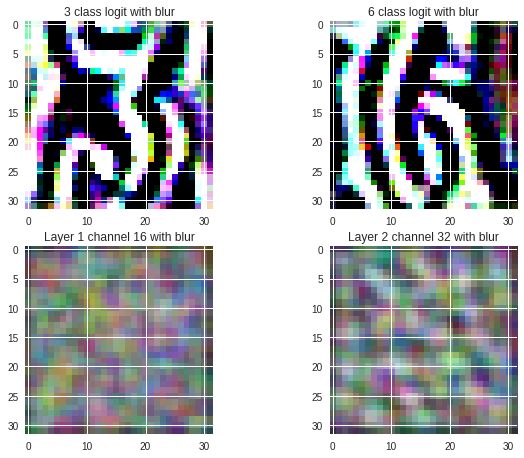

In [0]:
### add Gaussian blur to reduce high frequency noise

with G.as_default():
  
  cnn_model = Model(n1,n2,n3,W_conv1,b_conv1,W_conv2,b_conv2,W_fc1,b_fc1,W_fc2,b_fc2)
  rand = tf.Variable(tf.random.uniform([32,32,3],minval = 0, maxval = 1,dtype = tf.float32))
  rand_image = tf.reshape(rand,[-1,32,32,3])
  
  log_ind1 = 3
  log_ind2 = 6

  channel_ind1 = 16
  channel_ind2 = 32
  layer1 = 1
  layer2 = 2
  
  gk = gaussian_kernel(2,0.0,0.25)
  gk = gk[:, :, tf.newaxis, tf.newaxis]
  
  log_ind1_loss = cnn_model.get_logit_loss(rand_image,log_ind1)
  log_ind2_loss = cnn_model.get_logit_loss(rand_image,log_ind2)

  ts_log_ind1_loss = opt.minimize(-log_ind1_loss,var_list = [rand])
  ts_log_ind2_loss = opt.minimize(-log_ind2_loss,var_list = [rand])

  channel_ind1_loss = cnn_model.get_channel_loss(rand_image,layer1,channel_ind1,False)
  channel_ind2_loss = cnn_model.get_channel_loss(rand_image,layer2,channel_ind2,False)
  
  opt = tf.train.GradientDescentOptimizer(0.05)
  
  ts_log_ind1_loss = opt.minimize(-log_ind1_loss,var_list = [rand])
  ts_log_ind2_loss = opt.minimize(-log_ind2_loss,var_list = [rand])
  
  ts_channel_ind1_loss = opt.minimize(-channel_ind1_loss, var_list = [rand])
  ts_channel_ind2_loss = opt.minimize(-channel_ind2_loss, var_list = [rand])
  
  proj = tf.clip_by_value(rand,0,1)
  with tf.control_dependencies([proj]):
    proj_step = tf.assign(rand,proj)

  smoothed_im = gaussian_conv(rand_image,gk)
  with tf.control_dependencies([gk]):
    gb_step = tf.assign(rand,tf.reshape(smoothed_im,[32,32,3]))
    
  rand_image_plt = tf.reshape(rand_image,[32,32,3])
  
  with tf.Session() as sess:
    saver.restore(sess, "/tmp_svhn/model.ckpt")
    plt.figure(figsize=(10,20))
    
    
    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_log_ind1_loss)
      sess.run(gb_step)
      sess.run(proj_step)
   
    ax = plt.subplot(5,2,1)
    ax.set_title('%g class logit with blur'%(log_ind1))
    plt.imshow(rand_image_plt.eval())
 
    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_log_ind2_loss)
      sess.run(gb_step)
      sess.run(proj_step)
     

    ax = plt.subplot(5,2,2)
    ax.set_title('%g class logit with blur'%(log_ind2))
    plt.imshow(rand_image_plt.eval())
  
    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_channel_ind1_loss)
      sess.run(gb_step)
      sess.run(proj_step)
   
    ax = plt.subplot(5,2,3)
    ax.set_title('Layer %g channel %g with blur'%(layer1,channel_ind1))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_channel_ind2_loss)
      sess.run(gb_step)
      sess.run(proj_step)

    ax = plt.subplot(5,2,4)
    ax.set_title('Layer %g channel %g with blur'%(layer2,channel_ind2))
    plt.imshow(rand_image_plt.eval())
  

INFO:tensorflow:Restoring parameters from /tmp_svhn/model.ckpt


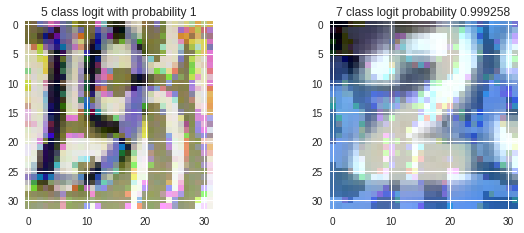

In [0]:
### Generating Adversarial Images

with G.as_default():
  
  delta = 0.1
  
  X_1 = tf.Variable(X_train[:,:,:,1])
  X_2 = tf.Variable(X_train[:,:,:,2])
  
  ind1 = 5
  ind2 = 7
  
  input_1 = tf.reshape(X_1,[-1,32,32,3])
  input_2 = tf.reshape(X_2,[-1,32,32,3])

  
  cnn_model = Model(n1,n2,n3,W_conv1,b_conv1,W_conv2,b_conv2,W_fc1,b_fc1,W_fc2,b_fc2)
  
  input1_loss = cnn_model.get_logit_loss(input_1,ind1)
  input2_loss = cnn_model.get_logit_loss(input_2,ind2)
  
  logits_1 = cnn_model.get_logits(input_1)
  probs_1 = tf.nn.softmax(logits_1)

  logits_2 = cnn_model.get_logits(input_2)
  probs_2 = tf.nn.softmax(logits_2)
  
  opt = tf.train.GradientDescentOptimizer(0.05)
  ts_input1_loss = opt.minimize(-input1_loss,var_list = [X_1])
  ts_input2_loss = opt.minimize(-input2_loss,var_list = [X_2])
  
  proj_1 = tf.clip_by_value(X_1,X_train[:,:,:,1] - delta,X_train[:,:,:,1]+delta)
  with tf.control_dependencies([proj_1]):
    proj1_step = tf.assign(X_1,proj_1)
  
  proj_2 = tf.clip_by_value(X_2,X_train[:,:,:,2] - delta,X_train[:,:,:,2]+delta)
  with tf.control_dependencies([proj_2]):
    proj2_step = tf.assign(X_2,proj_2)
    
  input_1_img = tf.reshape(input_1,[32,32,3])
  input_2_img = tf.reshape(input_2,[32,32,3])
  
  with tf.Session() as sess:
    saver.restore(sess, "/tmp_svhn/model.ckpt")
    plt.figure(figsize=(10,20))
    sess.run(tf.variables_initializer([X_1,X_2]))
    
    for i in range(1500):
      sess.run(ts_input1_loss)
      sess.run(proj1_step)
   
    _probs_1 = probs_1.eval()
    ax = plt.subplot(5,2,1)
    ax.set_title('5 class logit with probability %g'%(_probs_1[0,ind1]))
    plot_image(input_1_img.eval())
 
    sess.run(tf.variables_initializer([X_1,X_2]))
    for i in range(1500):
      sess.run(ts_input2_loss)
      sess.run(proj2_step)
     
    _probs_2 = probs_2.eval()
    ax = plt.subplot(5,2,2)
    ax.set_title('7 class logit probability %g'%(_probs_2[0,ind2]))
    plot_image(input_2_img.eval())
  
  
  
  
  